In [ ]:
# Importing the necessary Libraries

from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

Handwritten Character Recognition Method 1:

## Data collection

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/Mid-term-project/"

/content/drive/MyDrive/Mid-term-project


In [ ]:
!ls

'ascii (1).tgz'     'formsI-Z (1).tgz'	'parser (1).txt'     'xml (1).tgz'
 error_path.txt      Images_all.pickle	'sentences (1).tgz'
'formsA-D (1).tgz'   label_all.csv	 words
'formsE-H (1).tgz'  'lines (1).tgz'	 words.tar


In [ ]:

import tarfile
# open file
file = tarfile.open('/content/drive/MyDrive/Mid-term-project/words.tar')
# extracting file
file.extractall('./words')
file.close()

In [ ]:
!ls '/content/drive/MyDrive/Mid-term-project/words/'

a01  a06  b05  c04  d05  e04  f03  g03	h01  h07  k01  l01  m02  n02  p02  r06
a02  b01  b06  c06  d06  e06  f04  g04	h02  j01  k02  l03  m03  n03  p03
a03  b02  c01  d01  d07  e07  f07  g05	h04  j04  k03  l04  m04  n04  p06
a04  b03  c02  d03  e01  f01  g01  g06	h05  j06  k04  l07  m06  n06  r02
a05  b04  c03  d04  e02  f02  g02  g07	h06  j07  k07  m01  n01  p01  r03


Read the parser.txt file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model

Read the first 10000 from dataset

In [ ]:
# Read the first 10000 from dataset
with open('/content/drive/MyDrive/Mid-term-project/parser (1).txt') as f :
  contents = f.readlines()

lines = [line.strip() for line in contents ]
lines=lines[:10000]
lines[:10]

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more']

split the data to training , validation and testing samples

In [ ]:

words_list = []
for line in lines:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [ ]:
split_idx = int(0.9 * len(words_list)) # to take 90% from  data to training
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples)) # to take 5% from data to validation and test
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 7853
Total validation samples: 436
Total test samples: 437


Images can be of different shape thus resize all your images to have the same shape (forexample = (128,32)). Currently, the pixel values are between 0 to 255, normalize the images so that the pixel
values are in range 0 to 1

In [ ]:
base_image_path = os.path.join("words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

# Create a list of all characters and use the character’s index to encode the actual words into digits

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip() #to remove all white space characters—spaces, tabs, new lines
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  16
Vocab size:  74


['been',
 'Minister',
 'an',
 'service',
 'the',
 'are',
 'State',
 'Will',
 'the',
 'Brown']

In [ ]:
#validation and test data

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip() #to remove all white space characters—spaces, tabs, new lines
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

Building the character vocabulary

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Pad all the words to have a similar length

In [ ]:
# Resizing images without distortion

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image



In [ ]:
# Putting the utilities together


batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 #normalize the image
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
# Prepare tf.data.Dataset objects

train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


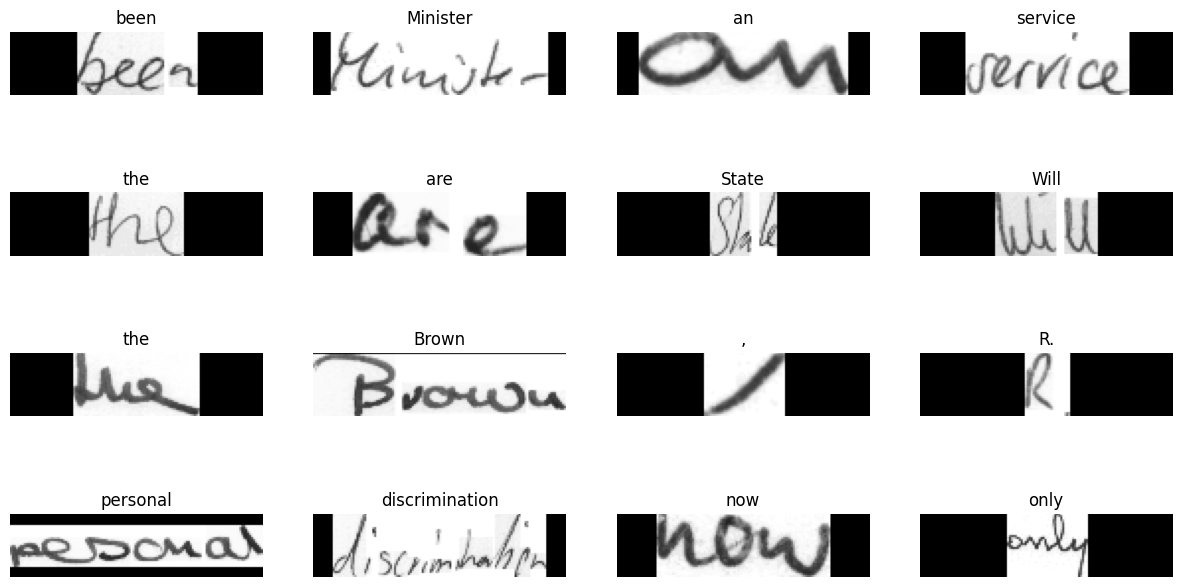

In [ ]:
# Visualize a few samples


for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

Create a model for training:                                                                                          
a)  Add several CNN layers to extract the sequence of features

b)  Add Bi-LSTM layers to propagate through the sequence

c)  Add a dense layer (output layer) with total number of neurons as (total number of characters + 1) and the activation as softmax.

In [ ]:
# Building the Model



class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)


    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [ ]:
#Evaluation metric

#We first segregate the validation images and their labels for convenience.
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:

#Now, we create a callback to monitor the edit distances.

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [ ]:
# Training
epochs = 128

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/128
2/2 [==============================] - 2s 109ms/step
Mean edit distance for epoch 1: 16.0000
123/123 [==============================] - 45s 193ms/step - loss: 20.7326 - val_loss: 15.8475
Epoch 2/128
2/2 [==============================] - 0s 13ms/step
Mean edit distance for epoch 2: 16.0000
123/123 [==============================] - 7s 56ms/step - loss: 15.5841 - val_loss: 15.2326
Epoch 3/128
2/2 [==============================] - 0s 11ms/step
Mean edit distance for epoch 3: 16.0000
123/123 [==============================] - 7s 60ms/step - loss: 14.9875 - val_loss: 14.4955
Epoch 4/128
2/2 [==============================] - 0s 10ms/step
Mean edit distance for epoch 4: 15.9672
123/123 [==============================] - 10s 79ms/step - loss: 14.6266 - val_loss: 14.2064
Epoch 5/128
2/2 [==============================] - 0s 14ms/step
Mean edit distance for epoch 5: 15.8068
123/123 [==============================] - 7s 58ms/step - loss: 14.3637 - val_loss: 13.9183
Epoch 6/128
2/2 

2/2 [==============================] - 0s 11ms/step


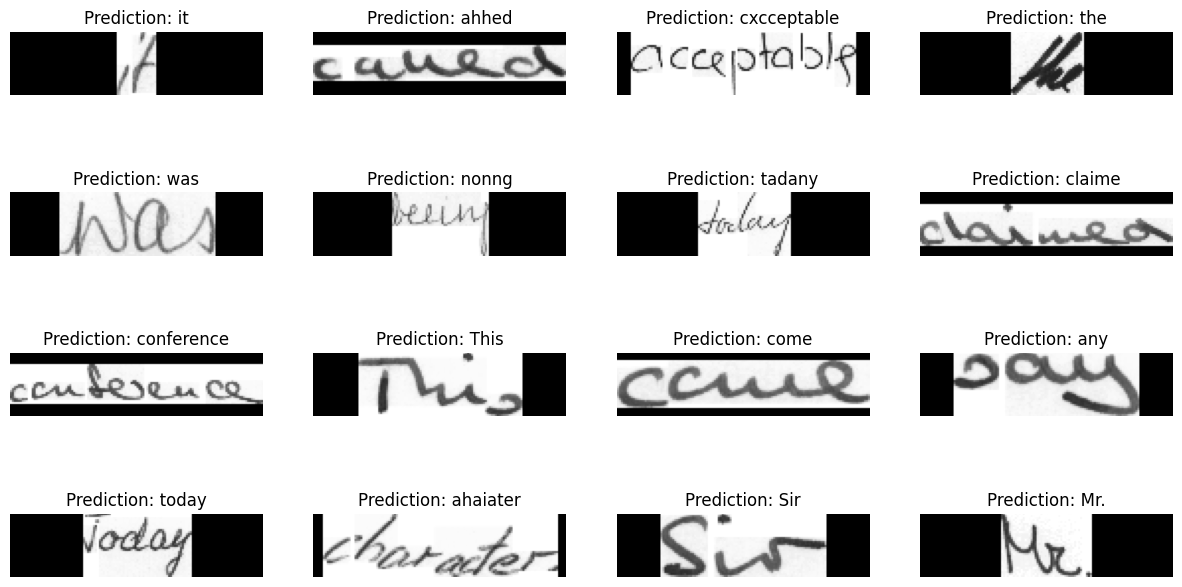

In [ ]:


# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

## Method 2 : Handwritten Character Recogition

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/Mid-term-project/"

/content/drive/MyDrive/Mid-term-project


In [ ]:
with open('/content/drive/MyDrive/Mid-term-project/parser (1).txt') as f:
    lines = f.readlines()
print(lines[115315:])
print(len(lines))

['r06-143-04-06 ok 186 1323 1428 64 77 PP3O him\n', 'r06-143-04-07 ok 186 1458 1469 36 52 IN in\n', 'r06-143-04-08 ok 186 1532 1445 73 72 ATI the\n', 'r06-143-04-09 ok 186 1654 1444 199 114 NN garden\n', 'r06-143-04-10 ok 186 1892 1453 36 66 ? ?']
115320


In [ ]:
l = []
for i in (lines):
  l.append(i.split(' '))
l[:5][1],l[:1][0][0]

(['a01-000u-00-01', 'ok', '154', '507', '766', '213', '48', 'NN', 'MOVE\n'],
 'a01-000u-00-00')

In [ ]:
!ls

'ascii (1).tgz'     'formsI-Z (1).tgz'	'parser (1).txt'     'xml (1).tgz'
 error_path.txt      Images_all.pickle	'sentences (1).tgz'
'formsA-D (1).tgz'   label_all.csv	 words
'formsE-H (1).tgz'  'lines (1).tgz'	 words.tar


In [ ]:

import cv2
import numpy as np

# resize image (paded base + Image)
def resize_img(ip_img):
  image = ip_img
  ht, wd = image.shape[0],image.shape[1]
  # create new image of required size and color for padding
  ww = 128
  hh = 32
  color = (0,0,0)
  result = 255 * np.ones((32,128), np.uint8)
  # set offsets for top left corner
  xx = 0
  yy = 0
  # copy img image into center of result image
  result[yy:yy+ht, xx:xx+wd] = image
  return result

####Load data and resize to (32,128) accoring to the parser.txt
def load_data(len):
  output = []
  images = []
  labels = []
  datacnt = 0
  cnt = 0

  # Iterate through each folder corresponding to a category
  for inp in l[:len]:
      datacnt += 1
      label = inp[-1:][0]
      s = inp[0].split("-")
      ext = inp[0]+'.png'
      path = "/content/drive/MyDrive/Mid-term-project/words/"+s[0]+"/"+s[0]+"-"+s[1]+"/"+ext
      curr_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      #curr_img = cv2.resize(curr_img, (128,32))

      if curr_img is None:
        print("Couldn't open file %s" % path)
        f = open("error_path.txt", "a")
        f.writelines([f'\n{path}'])
        f.close()
      else:
        w, h = curr_img.shape

        if h > 128 or w > 32:
            continue
        if w <= 32:

            add_zeros = np.ones((32-w, h))*255
            curr_img = np.concatenate((curr_img, add_zeros))

        if h <= 128:

            add_zeros = np.ones((32, 128-h))*255
            curr_img = np.concatenate((curr_img, add_zeros), axis=1)

        images.append(curr_img)
        labels.append(label)
        cnt += 1
        print(datacnt, cnt)
  return images,labels

In [ ]:
img,lab = load_data(len=115319)

Streaming output truncated to the last 5000 lines.
79665 8423
79684 8424
79690 8425
79696 8426
79706 8427
79719 8428
79726 8429
79733 8430
79749 8431
79778 8432
79787 8433
79800 8434
79812 8435
79829 8436
79838 8437
79851 8438
79873 8439
79876 8440
79886 8441
79903 8442
79914 8443
79930 8444
79942 8445
79951 8446
79970 8447
79981 8448
79994 8449
80002 8450
80009 8451
80027 8452
80056 8453
80078 8454
80085 8455
80104 8456
80135 8457
80183 8458
80210 8459
80229 8460
80245 8461
80247 8462
80249 8463
80282 8464
80320 8465
80324 8466
80353 8467
80369 8468
80428 8469
80456 8470
80477 8471
80481 8472
80497 8473
80525 8474
80558 8475
80575 8476
80600 8477
80609 8478
80611 8479
80634 8480
80697 8481
80699 8482
80707 8483
80722 8484
80727 8485
80732 8486
80752 8487
80786 8488
80812 8489
80820 8490
80831 8491
80835 8492
80846 8493
80850 8494
80861 8495
80884 8496
80894 8497
80910 8498
80914 8499
80927 8500
80942 8501
80960 8502
80969 8503
80981 8504
80990 8505
81010 8506
81013 8507
81015 8508
810

In [ ]:
# save images locally
import pickle

with open("Images_all.pickle", "wb") as file:
   pickle.dump(img, file)

In [ ]:
#import pandas as pd

df = pd.DataFrame({'label': lab})
df['label']=df.label.str.rstrip('\n')
df.to_csv('label_all.csv', index = False)

In [ ]:
# Load the image file
import pickle
# load images
with open("Images_all.pickle", "rb") as file:
    images = pickle.load(file)

In [ ]:
# load the label text file
import pandas as pd
data = pd.read_csv('label_all.csv')
data.head()

,label
0,.
1,a
2,on
3,.
4,.


In [ ]:
import numpy as np
X =  np.array(images[:], dtype = 'float32')
X = X / 255
X = np.expand_dims(X , axis = 3)
X.shape

(13421, 32, 128, 1)

In [ ]:
y = data['label'][:]
y.shape

(13421,)

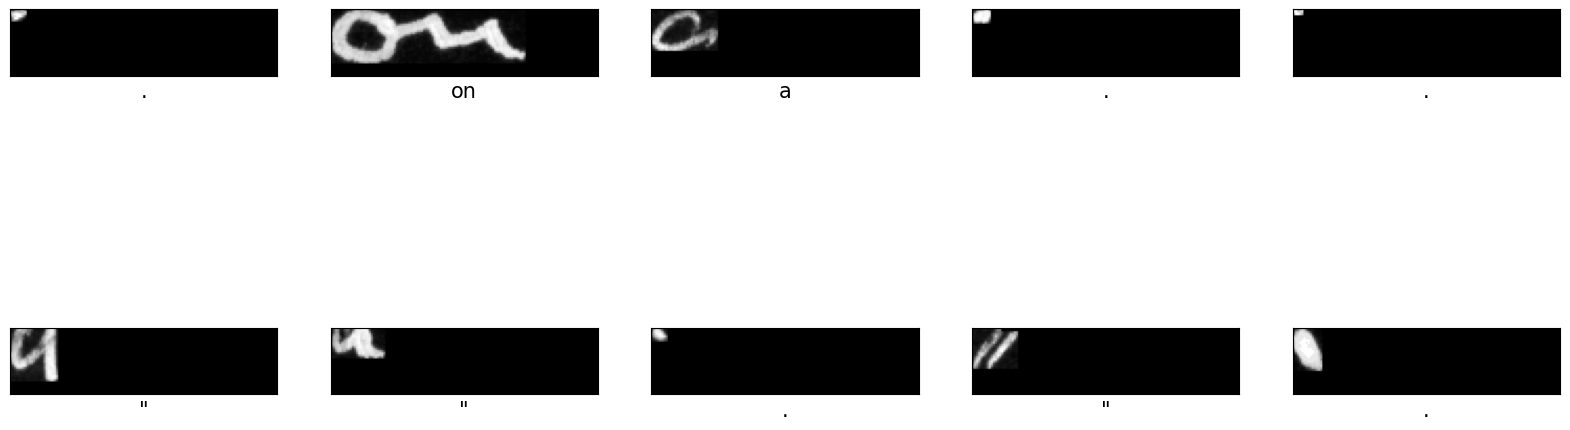

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
randomlist = random.sample(range(0, 1000), 10)

fig = plt.figure(figsize=(20,20))

for i,j in enumerate(randomlist):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X[j].reshape(32,128) , cmap = 'gray_r')
  plt.xlabel(y[j], fontsize=15)
plt.show()

In [ ]:
# Get all alphabets to one list
y_cat = y.apply(lambda x: [y for y in x])
c = []
for i in y_cat:
  for j in i:
    c.append(j)
u_l = np.unique(c)
#print(u_l)

# Get the special char in the labels
import string
spl_char = []
for i in u_l:
  if i not in string.ascii_letters+string.digits:
    spl_char.append(i)
spl_char=''.join(spl_char)
spl_char

'!"#&\'(),-.:;?'

In [ ]:
import string
char_list = string.ascii_letters+string.digits
char_list.split(',')

for i,v in enumerate(char_list):
  print(i,':',v)

0 : a
1 : b
2 : c
3 : d
4 : e
5 : f
6 : g
7 : h
8 : i
9 : j
10 : k
11 : l
12 : m
13 : n
14 : o
15 : p
16 : q
17 : r
18 : s
19 : t
20 : u
21 : v
22 : w
23 : x
24 : y
25 : z
26 : A
27 : B
28 : C
29 : D
30 : E
31 : F
32 : G
33 : H
34 : I
35 : J
36 : K
37 : L
38 : M
39 : N
40 : O
41 : P
42 : Q
43 : R
44 : S
45 : T
46 : U
47 : V
48 : W
49 : X
50 : Y
51 : Z
52 : 0
53 : 1
54 : 2
55 : 3
56 : 4
57 : 5
58 : 6
59 : 7
60 : 8
61 : 9


In [ ]:
# encoding each output word into digits
def encode_to_labels(txt):

    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            pass

    return dig_lst

In [ ]:
num_data = 13440
org_txt_all = []  # Contains actual text
code_txt_all = [] # Contains coded form of actual text
img_list_all = [] # Contains images
label_length_all = [] #Contains actual text lengths
input_length_all = [] #Contains max of lable len

for idx,txt in enumerate(y[:num_data]):
  if len(txt)>=2:
    org_txt_all.append(txt)
    img_list_all.append(X[idx])
    code_txt_all.append(encode_to_labels(txt))
    label_length_all.append(len(txt))
    input_length_all.append(31)

In [ ]:
len(org_txt_all),len(code_txt_all),len(img_list_all),len(label_length_all),len(input_length_all)

(1889, 1889, 1889, 1889, 1889)

In [ ]:
org_txt , test_org_txt = org_txt_all[:1850] , org_txt_all[1851:]
code_txt , test_code_txt = code_txt_all[:1850] , code_txt_all[1851:]
img_list , test_img_list = img_list_all[:1850] , img_list_all[1851:]
label_length , test_label_length = label_length_all[:1850] , label_length_all[1851:]
input_length , test_input_length = input_length_all[:1850] , input_length_all[1851:]

# Contains actual text
# Contains coded form of actual text
# Contains images
#Contains actual text lengths
#Contains max of lable len

In [ ]:
len(org_txt),len(code_txt),len(img_list),len(label_length),len(input_length)

(1850, 1850, 1850, 1850, 1850)

In [ ]:
len(test_org_txt),len(test_code_txt),len(test_img_list),len(test_label_length),len(test_input_length)

(38, 38, 38, 38, 38)

In [ ]:
org_txt = org_txt+org_txt+org_txt+org_txt+org_txt+org_txt[:750]
code_txt = code_txt+code_txt+code_txt+code_txt+code_txt+code_txt[:750]
img_list = img_list+img_list+img_list+img_list+img_list+img_list[:750]
label_length = label_length+label_length+label_length+label_length+label_length+label_length[:750]
input_length =input_length+input_length+input_length+input_length+input_length+input_length[:750]

In [ ]:
len(org_txt),len(code_txt),len(img_list),len(label_length),len(input_length)

(10000, 10000, 10000, 10000, 10000)

In [ ]:
# Get max possible char length
max_char_len = max(label_length)
max_char_len

10

In [ ]:
np.unique(label_length)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

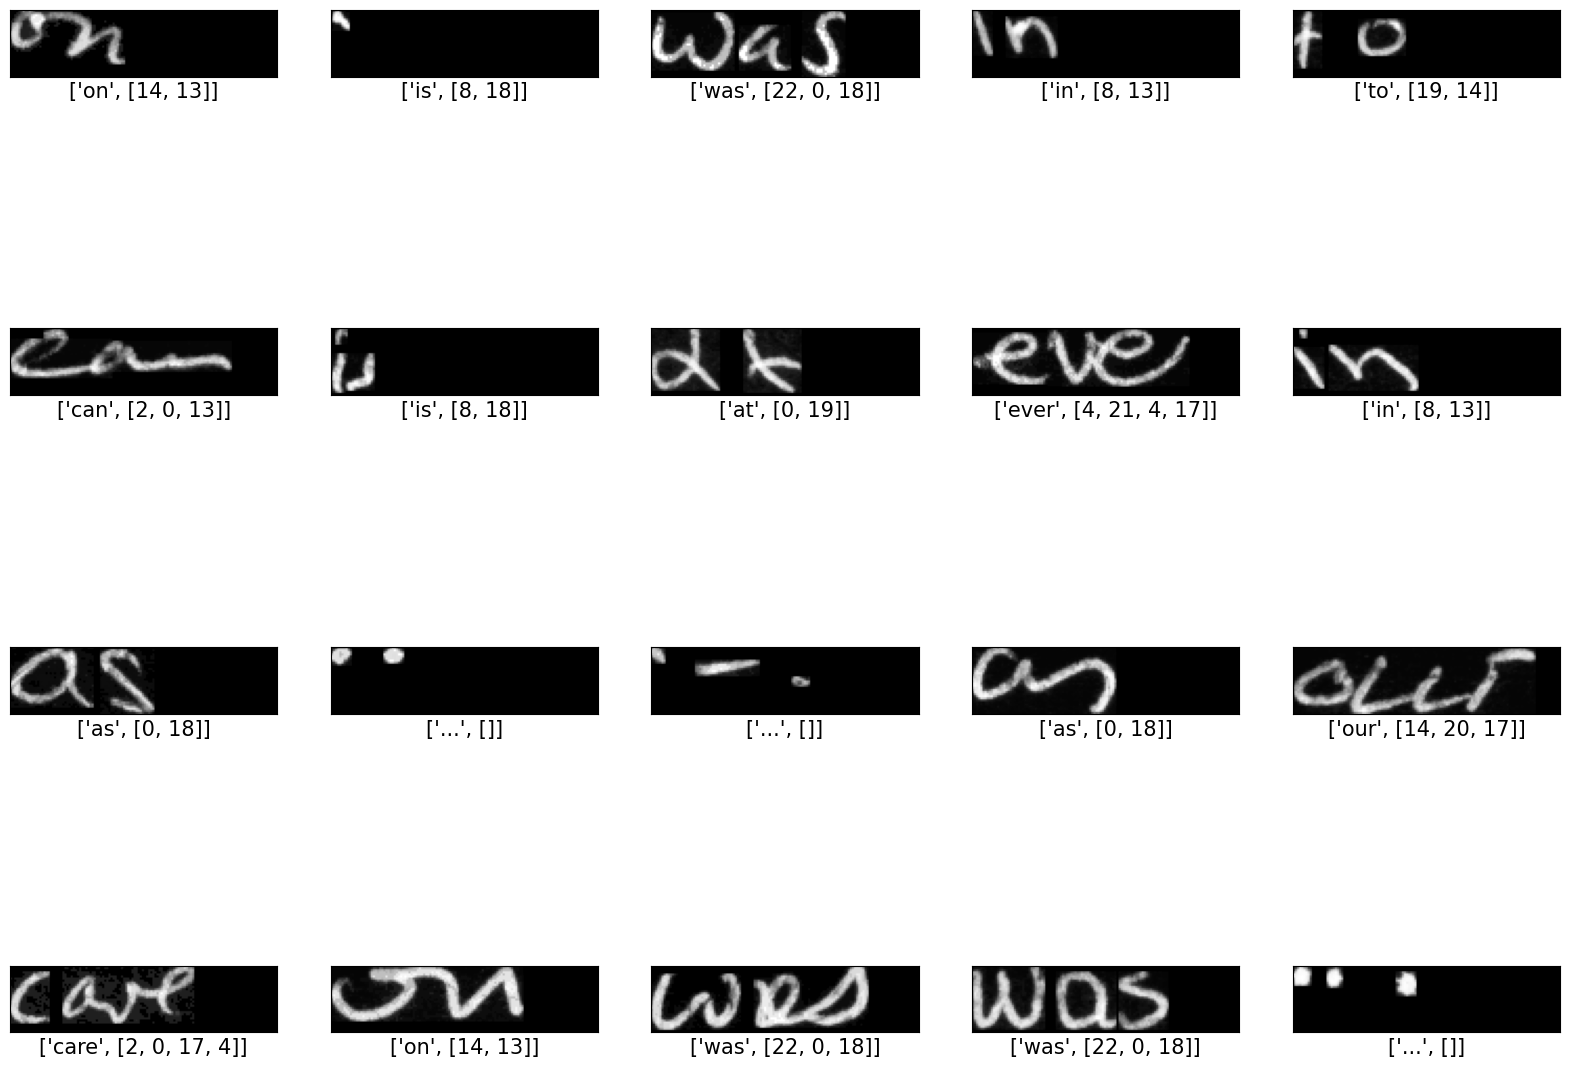

[6709, 265, 1819, 6804, 7895, 2180, 3896, 6387, 4707, 6823, 315, 9248, 8986, 9116, 7852, 4851, 3745, 3810, 814, 6744]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
randomlist = random.sample(range(0, len(org_txt)-1), 20)

fig = plt.figure(figsize=(20,20))

for i,j in enumerate(randomlist):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img_list[j].reshape(32,128) , cmap = 'gray_r')
  plt.xlabel([org_txt[j],code_txt[j]], fontsize=15)
plt.show()
print(randomlist)

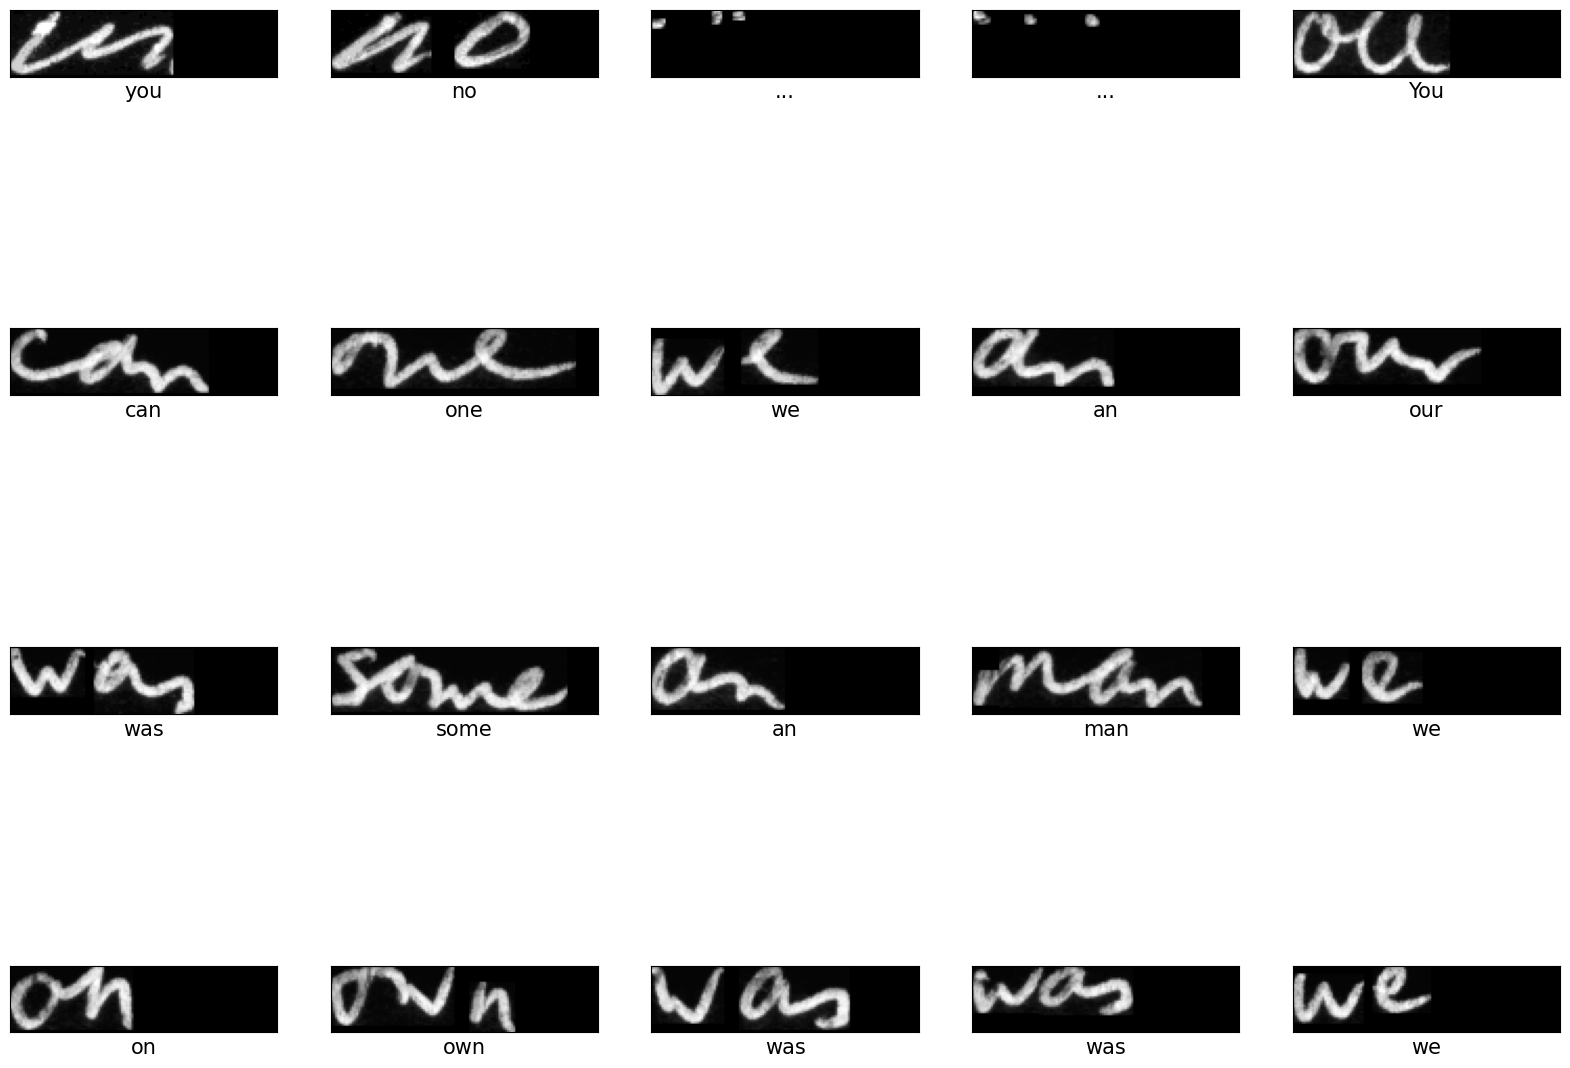

[12, 18, 26, 7, 20, 21, 33, 23, 5, 2, 22, 4, 34, 27, 16, 15, 8, 19, 0, 17]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
randomlist = random.sample(range(0, len(test_org_txt)-1), 20)

fig = plt.figure(figsize=(20,20))

for i,j in enumerate(randomlist):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_img_list[i].reshape(32,128) , cmap = 'gray_r')
  plt.xlabel(test_org_txt[i], fontsize=15)
plt.show()
print(randomlist)

In [ ]:
np.unique(test_label_length)

array([2, 3, 4])

In [ ]:
# Get all label data to a DF to use in train_test_split
y_df = pd.DataFrame(np.array(code_txt),
                   columns=['y_coded'])
y_df['label_length'] = label_length
y_df['input_length'] = input_length
y_df['org_txt'] = org_txt
y_df

<ipython-input-125-0cb3e6c43596>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_df = pd.DataFrame(np.array(code_txt),


,y_coded,label_length,input_length,org_txt
0,"[14, 13]",2,31,on
1,"[0, 18]",2,31,as
2,"[13, 14, 22]",3,31,now
3,"[20, 15]",2,31,up
4,"[11, 8, 13, 4]",4,31,line
...,...,...,...,...
9995,"[22, 0, 18]",3,31,was
9996,"[19, 14, 14]",3,31,too
9997,"[33, 4]",2,31,He
9998,"[14, 13, 4]",3,31,one


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_list, y_df, test_size=0.10, random_state=42)

In [ ]:
np.shape(X_train),y_train.shape,np.shape(X_test),y_test.shape

((9000, 32, 128, 1), (9000, 4), (1000, 32, 128, 1), (1000, 4))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D,Bidirectional,LSTM,Lambda,Input,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.models import Model

# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

convolution1 = Conv2D(filters=64, kernel_size=(1,1))(inputs)
convolution1 = BatchNormalization(axis = -1)(convolution1)
convolution1 = Activation("relu")(convolution1)

convolution2 = Conv2D(filters=64, kernel_size=(1,1))(convolution1)
convolution2 = BatchNormalization(axis = -1)(convolution2)
convolution2 = Activation("relu")(convolution2)

pooling1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(convolution2)

convolution3 = Conv2D(filters=128, kernel_size=(1,1))(pooling1)
convolution3 = BatchNormalization(axis = -1)(convolution3)
convolution3 = Activation("relu")(convolution3)

convolution4 = Conv2D(filters=128, kernel_size=(1,1))(convolution3)
convolution4 = BatchNormalization(axis = -1)(convolution4)
convolution4 = Activation("relu")(convolution4)

pooling2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(convolution4)

convolution5 = Conv2D(filters=256, kernel_size=(1,1))(pooling2)
convolution5 = BatchNormalization(axis = -1)(convolution5)
convolution5 = Activation("relu")(convolution5)

convolution6 = Conv2D(filters=256, kernel_size=(1,1))(convolution5)
convolution6 = BatchNormalization(axis = -1)(convolution6)
convolution6 = Activation("relu")(convolution6)

convolution7 = Conv2D(filters=256, kernel_size=(1,1))(convolution6)
convolution7 = BatchNormalization(axis = -1)(convolution7)
convolution7 = Activation("relu")(convolution7)

pooling3 = MaxPooling2D(pool_size=(2,1), strides=(2,1))(convolution7)

convolution8 = Conv2D(filters=512, kernel_size=(1,1))(pooling3)
convolution8 = BatchNormalization(axis = -1)(convolution8)
convolution8 = Activation("relu")(convolution8)

convolution9 = Conv2D(filters=512, kernel_size=(1,1))(convolution8)
convolution9 = BatchNormalization(axis = -1)(convolution9)
convolution9 = Activation("relu")(convolution9)

convolution10 = Conv2D(filters=512, kernel_size=(1,1))(convolution9)
convolution10= BatchNormalization(axis = -1)(convolution10)
convolution10 = Activation("relu")(convolution10)

pooling4 = MaxPooling2D(pool_size=(2,1), strides=(2,1))(convolution10)

convolution11 = Conv2D(filters=512, kernel_size=(1,1))(pooling4)
convolution11= BatchNormalization(axis = -1)(convolution11)
convolution11 = Activation("relu")(convolution11)

convolution12 = Conv2D(filters=512, kernel_size=(1,1))(convolution11)
convolution12= BatchNormalization(axis = -1)(convolution12)
convolution12 = Activation("relu")(convolution12)

convolution13 = Conv2D(filters=512, kernel_size=(1,1))(convolution12)
convolution13= BatchNormalization(axis = -1)(convolution13)
convolution13 = Activation("relu")(convolution13)

pooling5 = MaxPooling2D(pool_size=(2,1), strides=(2,1))(convolution13)
convolution14 = Conv2D(512, (1,2), activation = 'relu')(pooling5)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(convolution14)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

# The output of size (batch_size, 31, 76). Where 76 is the total number of output classes including blank character.
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# Combine to model
act_model = Model(inputs, outputs)

In [ ]:
# Use CTC_loss and CTC_decode (Connectionist Temporal Categorical)

labels = Input(name='the_labels', shape=[max_char_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

In [ ]:
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
from keras.optimizers import Adam,RMSprop,SGD,Adadelta,Adamax,Nadam,Adagrad
#opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#opt = Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
#opt = Adadelta(learning_rate=0.0001, rho=1, epsilon=1e-07)
#opt = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#opt = Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07)
opt = RMSprop(learning_rate=0.0001,rho=0.9,momentum=0.9,epsilon=1e-07)

In [ ]:

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = opt, metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 128, 64)  128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 32, 128, 64)  256        ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
checkpoint = ModelCheckpoint(filepath="htr_model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#es = EarlyStopping (monitor= 'val_loss',patience= 10)
lrp = ReduceLROnPlateau(monitor= 'val_loss' ,patience = 10)
callbacks_list = [checkpoint,lrp]

In [ ]:
! pip install keras --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

from keras.utils import pad_sequences

training_img = np.array(X_train)
train_input_length = np.array(y_train['input_length'])
train_label_length = np.array(y_train['label_length'])
# Pad the coded text to max length with the maximum encodednum+1 as this is for the char outside our list
train_padded_txt = pad_sequences(y_train['y_coded'], maxlen=max_char_len, padding='post', value = len(char_list))
train_org_txt = np.array(y_train['org_txt'])

valid_img = np.array(X_test)
valid_input_length = np.array(y_test['input_length'])
valid_label_length = np.array(y_test['label_length'])
# Pad the coded text to max length with the maximum encodednum+1 as this is for the char outside our list
valid_padded_txt = pad_sequences(y_test['y_coded'], maxlen=max_char_len, padding='post', value = len(char_list))
valid_org_txt = np.array(y_test['org_txt'])

In [ ]:
train_padded_txt[1]

array([14, 17, 62, 62, 62, 62, 62, 62, 62, 62], dtype=int32)

In [ ]:
np.unique(valid_label_length)

array([2, 3, 4, 5, 6, 7, 8])

In [ ]:
batch_size = 252
epochs = 100
history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=train_padded_txt,
          batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], valid_padded_txt),shuffle=True,
          verbose = 1, callbacks = callbacks_list)

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 16.0729 - accuracy: 5.0000e-04
Epoch 1: val_loss improved from inf to 7.48152, saving model to htr_model.hdf5
36/36 [==============================] - 41s 696ms/step - loss: 16.0729 - accuracy: 5.0000e-04 - val_loss: 7.4815 - val_accuracy: 7.0000e-04 - lr: 1.0000e-04
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 6.9520 - accuracy: 5.0000e-04
Epoch 2: val_loss improved from 7.48152 to 7.43637, saving model to htr_model.hdf5
36/36 [==============================] - 14s 378ms/step - loss: 6.9520 - accuracy: 5.0000e-04 - val_loss: 7.4364 - val_accuracy: 7.0000e-04 - lr: 1.0000e-04
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 6.4267 - accuracy: 5.0000e-04
Epoch 3: val_loss did not improve from 7.43637
36/36 [==============================] - 14s 388ms/step - loss: 6.4267 - accuracy: 5.0000e-04 - val_loss: 7.8960 - val_accuracy: 7.0000e-04 - lr: 1.0000e-04
Epoch 4/100
36/36 [==

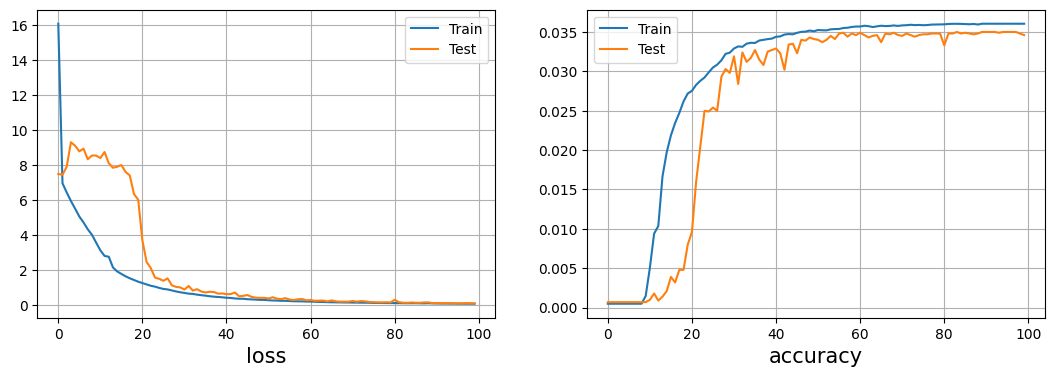

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(13,4))
mat = [['loss','val_loss'],['accuracy','val_accuracy']]

for i in range(2):
  plt.subplot(1,2,i+1)
  for j in range(2):
    plt.plot(history.history[mat[i][j]])
    plt.legend(['Train','Test'])
    plt.xlabel(mat[i][0], fontsize=15)
  plt.grid()
plt.show()

In [ ]:
# load the saved model weights
act_model.load_weights('htr_model.hdf5')

In [ ]:
# The test data to check how model respond to the new images

test_img = np.array(test_img_list)
test_input_length = np.array(test_input_length)
test_label_length = np.array(test_label_length)
# Pad the coded text to max length with the maximum encodednum+1 as this is for the char outside our list
test_padded_txt = pad_sequences(test_code_txt, maxlen=max_char_len, padding='post', value = len(char_list))
test_org_txt = np.array(test_org_txt)

In [ ]:
valid_sp = []
index = []
valid_img_sp = []
for i,v in enumerate(valid_org_txt[:]):
  if len(v) >= 2:
    valid_sp.append(v)
    index.append(i)
for i in index:
  valid_img_sp.append(valid_img[i])
valid_img_sp = np.array(valid_img_sp)

In [ ]:
# prediction on validation images
prediction = act_model.predict(valid_img_sp[:])

# CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

32/32 [==============================] - 2s 22ms/step


In [ ]:
out

array([[ 0, 13, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [14, 20, 17, ..., -1, -1, -1],
       ...,
       [ 2,  0, 13, ..., -1, -1, -1],
       [ 0, 18, -1, ..., -1, -1, -1],
       [ 0, 13, -1, ..., -1, -1, -1]])

In [ ]:
# see the results
pred_txt= []
for arr in out:
  arr = arr[arr != -1]
  txt = ''
  for p in range(len(arr)):
    txt = txt+char_list[int(arr[p])]
  pred_txt.append(txt)

cnt = 0
for i in range(len(out)):
    if valid_sp[i] == pred_txt[i]:
      cnt += 1


In [ ]:
# see the results
for i in range(len(out)):
    if valid_sp[i] == pred_txt[i]:
      print("Original text:", valid_sp[i], "=>>","Predicted text:", pred_txt[i],"==>>matched")
    else:
      print("Original text:", valid_sp[i], "=>>","Predicted text:", pred_txt[i])

Original text: an =>> Predicted text: an ==>>matched
Original text: ... =>> Predicted text: 
Original text: our =>> Predicted text: our ==>>matched
Original text: no =>> Predicted text: no ==>>matched
Original text: was =>> Predicted text: was ==>>matched
Original text: as =>> Predicted text: as ==>>matched
Original text: no =>> Predicted text: no ==>>matched
Original text: or =>> Predicted text: or ==>>matched
Original text: new =>> Predicted text: new ==>>matched
Original text: was =>> Predicted text: was ==>>matched
Original text: man =>> Predicted text: man ==>>matched
Original text: or =>> Predicted text: or ==>>matched
Original text: was =>> Predicted text: was ==>>matched
Original text: on =>> Predicted text: on ==>>matched
Original text: now =>> Predicted text: now ==>>matched
Original text: an =>> Predicted text: an ==>>matched
Original text: on =>> Predicted text: on ==>>matched
Original text: are =>> Predicted text: are ==>>matched
Original text: was =>> Predicted text: was 